In [52]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('fivethirtyeight')


In [53]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


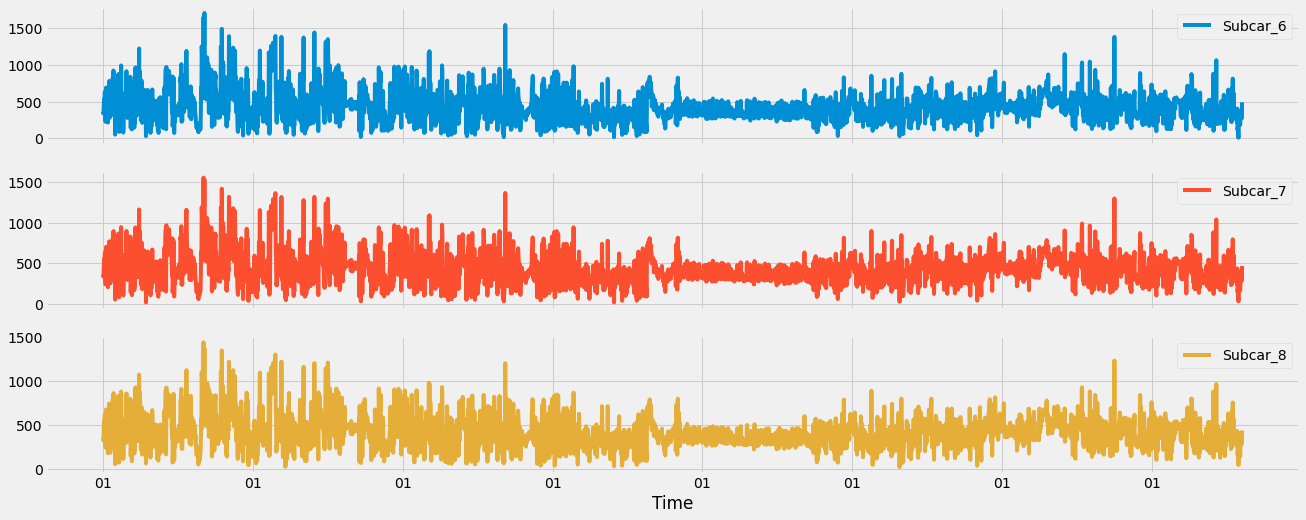

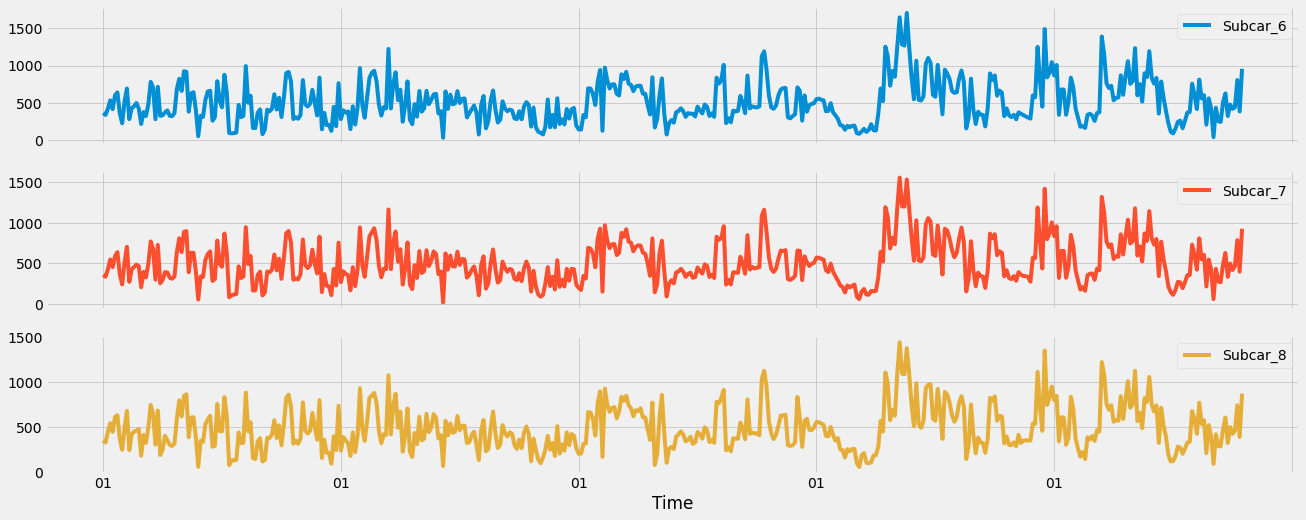

In [54]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_1.png', dpi=500,)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_2.png', dpi=500,)



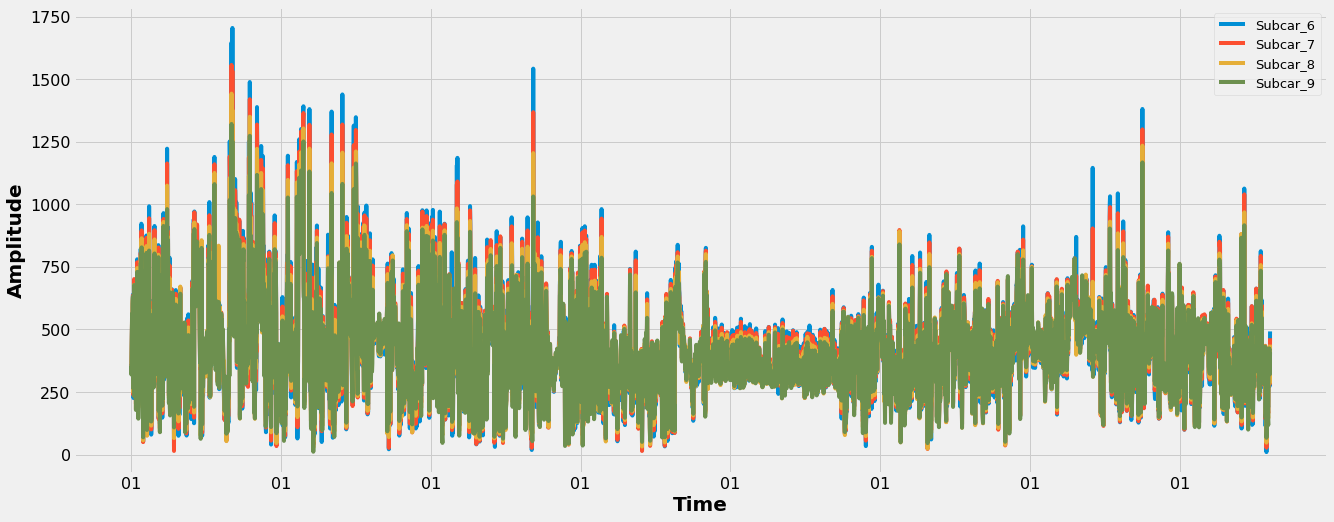

In [55]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold', horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
# plt.savefig('../images/raw_data.pdf', dpi=300)


In [56]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [57]:
df_input = data_2[['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']]
df_input.head()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
Time,,,,
1970-01-01 00:00:01.641598542,362.527240,353.411941,351.432782,353.793725
1970-01-01 00:00:01.641598543,338.013313,332.434956,327.232333,319.820262
1970-01-01 00:00:01.641598544,421.911128,424.001179,447.754397,441.279957
1970-01-01 00:00:01.641598545,533.348854,545.424605,542.492396,562.694411
1970-01-01 00:00:01.641598546,415.226444,450.480854,445.583887,458.423385


In [58]:
df_input.describe()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
count,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,413.767333,410.627681
std,202.453002,193.543158,181.690717,171.775869
min,10.295630,14.764823,24.207437,11.661904
25%,295.032201,300.879956,300.189524,301.906856
50%,391.523942,393.309005,389.432916,387.431284
75%,511.462363,509.395703,500.228934,496.494461
max,1704.556541,1556.767484,1442.231951,1320.984860


In [59]:
df_input.query("Subcar_6 > 600")


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
Time,,,,
1970-01-01 00:00:01.641598547,602.844093,587.749096,612.885797,601.239553
1970-01-01 00:00:01.641598547,639.425523,635.824661,629.924599,631.708794
1970-01-01 00:00:01.641598550,691.112871,701.485567,678.552135,677.784627
1970-01-01 00:00:01.641598556,780.515855,768.584413,745.410625,730.010959
1970-01-01 00:00:01.641598556,708.138405,675.931949,646.845422,620.697189
...,...,...,...,...
1970-01-01 00:00:01.641600092,663.272191,663.451581,634.461189,615.210533
1970-01-01 00:00:01.641600103,615.646814,626.744765,609.397243,609.118215
1970-01-01 00:00:01.641600103,690.676480,678.564662,658.891493,656.966514


In [60]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
       [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
       [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
       ...,
       [-0.27743919, -0.20720092, -0.15398159,  0.07324638],
       [-0.73269987, -0.72525887, -0.70052711, -0.52228415],
       [ 0.34273106,  0.22060855,  0.14296075, -0.015185  ]])

In [61]:
features = data_scaled
target = data_scaled[:, 0]


In [62]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[0]


(array([[[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
         [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         [-0.03806624,  0.14494217,  0.17513684,  0.27828118],
         [ 0.88877764,  0.85427387,  1.09606401,  1.1098005 ]]]),
 array([1.06949239]))

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 4)
X_test.shape:  (761, 4)


In [64]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [65]:
train_generator[0]


(array([[[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
         [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         ...,
         [-0.31770112, -0.29853529, -0.22009508, -0.20091622],
         [-0.17366199, -0.13916572, -0.01731661,  0.10073881],
         [-1.93023053, -2.10609108, -1.91410552, -1.75742493]],
 
        [[-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         ...,
         [-0.17366199, -0.13916572, -0.01731661,  0.10073881],
         [-1.93023053, -2.10609108, -1.91410552, -1.75742493],
         [ 1.13459881,  1.01863711,  0.8513744 ,  0.67052056]],
 
        [[-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         [-0.03806624,  0.14494217,  0.17513684,  0.27828118],
         ...,
       

In [66]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, 'linear')
])

lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 144, 128)          68096     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [67]:
cp1 = ModelCheckpoint('../save/lstm_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

In [68]:
history_1 = lstm_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/15
91/91 [==============================] - 27s 294ms/step - loss: 0.9676 - mean_absolute_error: 0.7193 - val_loss: 0.5997 - val_mean_absolute_error: 0.5822
Epoch 2/15
91/91 [==============================] - 28s 307ms/step - loss: 0.8978 - mean_absolute_error: 0.6898 - val_loss: 0.5844 - val_mean_absolute_error: 0.5705
Epoch 3/15
91/91 [==============================] - 31s 343ms/step - loss: 0.8555 - mean_absolute_error: 0.6731 - val_loss: 0.5672 - val_mean_absolute_error: 0.5598
Epoch 4/15
91/91 [==============================] - 30s 333ms/step - loss: 0.8194 - mean_absolute_error: 0.6539 - val_loss: 0.5518 - val_mean_absolute_error: 0.5500
Epoch 5/15
91/91 [==============================] - 32s 357ms/step - loss: 0.7813 - mean_absolute_error: 0.6368 - val_loss: 0.5443 - val_mean_absolute_error: 0.5454
Epoch 6/15
91/91 [==============================] - 33s 367ms/step - loss: 0.7734 - mean_absolute_error: 0.6303 - val_loss: 0.5426 - val_mean_absolute_error: 0.5437
Epoch 7/15

In [69]:
history_1.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [70]:
def vis(history, name):
    plt.title(f"{name.upper()}", fontsize=13)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel(f"{name.lower()}", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}", None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None:
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(
        0.05, 1.2), fontsize=16, ncol=1)


def plot_history(history):
    key_value = list(set([i.split("val_")[-1]
                     for i in list(history.history.keys())]))
    plt.figure(figsize=(20, 8))
    for idx, key in enumerate(key_value):
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

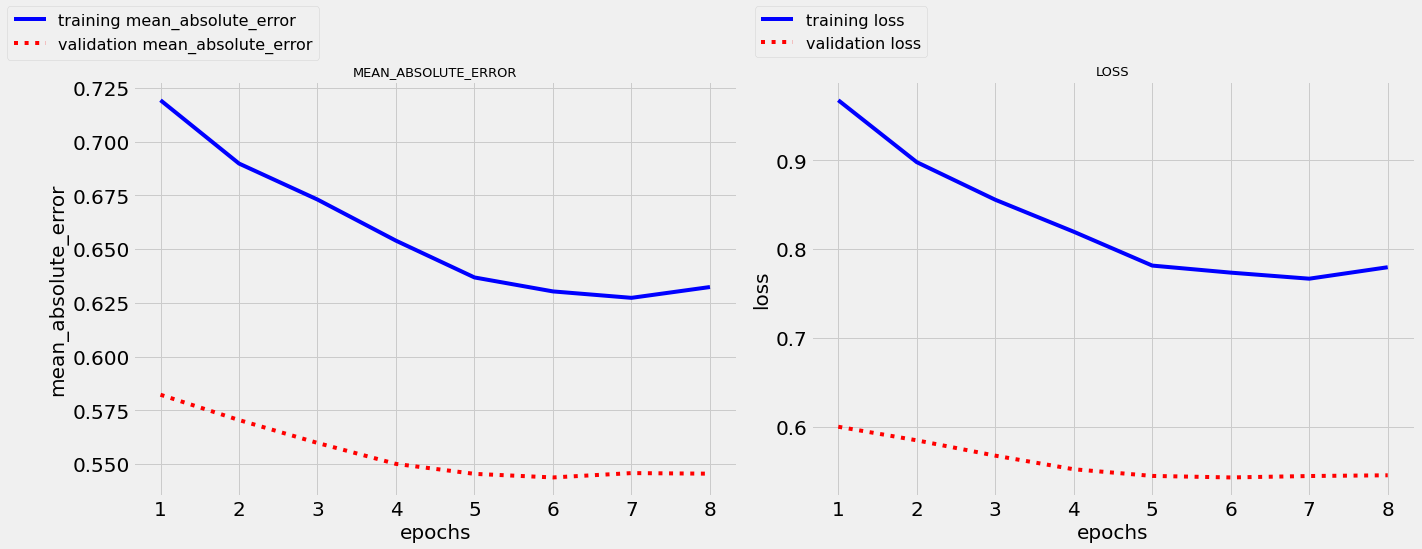

In [72]:
plot_history(history_1)

In [73]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 8s 84ms/step - loss: 0.7829 - mean_absolute_error: 0.6331


In [74]:
predictions_lstm = lstm_model.predict(test_generator)

In [75]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/lstm_model_standard/')

In [76]:
predictions_lstm.shape[0]


617

In [77]:
predictions_lstm


array([[ 2.54487664e-01],
       [ 3.70423377e-01],
       [ 5.08361220e-01],
       [ 5.27471066e-01],
       [ 6.04795694e-01],
       [ 3.78752172e-01],
       [ 2.40328535e-01],
       [ 2.63951987e-01],
       [ 3.91638577e-01],
       [ 3.98933351e-01],
       [ 2.98685670e-01],
       [ 3.72944742e-01],
       [ 4.32320714e-01],
       [ 2.13579059e-01],
       [ 2.10408289e-02],
       [-2.65467353e-03],
       [ 3.93170640e-02],
       [ 1.82662666e-01],
       [ 2.59996593e-01],
       [ 1.49849489e-01],
       [ 1.65022850e-01],
       [ 8.41966197e-02],
       [ 3.79384980e-02],
       [-7.85379410e-02],
       [-8.81488472e-02],
       [ 5.05977929e-01],
       [-3.70705053e-02],
       [-1.30769655e-01],
       [-1.88543200e-01],
       [-8.00976083e-02],
       [-4.82481718e-02],
       [-3.08552161e-02],
       [-1.57501828e-02],
       [ 2.88325567e-02],
       [ 5.73653579e-02],
       [ 8.37308392e-02],
       [-5.71873970e-03],
       [-4.86513823e-02],
       [ 1.7

In [78]:
y_test


array([-2.23392455e-01,  2.60466969e-01,  3.04683782e-01, -3.79392915e-01,
       -2.87156246e-01, -2.87975706e-01, -3.00128488e-01, -2.92581092e-01,
       -2.50479368e-01, -1.00799095e+00, -8.43377374e-01,  4.89444939e-01,
       -6.68521687e-01, -4.71186287e-01,  4.76061840e-01,  4.32817763e-01,
       -1.55416865e-01,  8.45012376e-01,  1.09786157e+00, -8.75551265e-02,
       -2.33234157e-01, -9.43267223e-02, -8.34447427e-02,  9.86747017e-01,
        3.90094148e-01, -5.58370143e-01,  3.41692396e-02,  5.66560401e-01,
       -5.54350399e-01, -7.17058563e-01, -3.06660276e-01, -8.01659913e-01,
       -5.87914333e-01, -6.02278754e-01, -3.57179843e-01, -3.77274810e-01,
       -2.31236691e-01, -3.10332942e-01,  3.96419909e-01,  3.11915656e-01,
       -1.69252861e-01, -1.03713012e-01, -5.99737163e-01, -2.87156246e-01,
        5.29039403e-01,  2.19475101e-01,  3.07251279e-01, -5.71160172e-01,
        1.36296029e+00, -1.29876322e+00,  3.95855326e-01, -5.45820473e-01,
        2.99050096e-01,  

In [79]:
x_test


array([[-0.22339246, -0.17800668, -0.13104803, -0.09350367],
       [ 0.26046697,  0.29052298,  0.33157891,  0.36036737],
       [ 0.30468378,  0.40193209,  0.34824829,  0.43489046],
       ...,
       [-0.27743919, -0.20720092, -0.15398159,  0.07324638],
       [-0.73269987, -0.72525887, -0.70052711, -0.52228415],
       [ 0.34273106,  0.22060855,  0.14296075, -0.015185  ]])

In [ ]:
x_test[:, 1:][win_length:]


In [80]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2
0,0.254488,1.024170,1.181653,1.223469
1,0.370423,1.299629,1.682031,1.646456
2,0.508361,1.254683,1.393705,1.441127
3,0.527471,1.428023,1.518551,1.610747
4,0.604796,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.369147,-0.139950,-0.002518,0.078249
613,-0.204478,-0.213699,-0.106270,-0.033622
614,-0.179485,-0.207201,-0.153982,0.073246
615,-0.176638,-0.725259,-0.700527,-0.522284


In [81]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[474.44707072, 620.6271022 , 628.434563  , 620.7624344 ],
       [497.91551697, 673.9332311 , 719.3364998 , 693.4118545 ],
       [525.8377748 , 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [386.59959171, 382.3349317 , 385.7939865 , 423.2079867 ],
       [387.17584248, 282.0815485 , 286.5047993 , 320.9236669 ],
       [361.43234889, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [82]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]


In [83]:
df_final_lstm.count()


Subcar_6    617
Subcar_7    617
Subcar_8    617
Subcar_9    617
dtype: int64

In [84]:
df_final_lstm['Subcar_6_pred'] = rev_trans[:, 0]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_6_pred
Time,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,474.447071
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,497.915517
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,525.837775
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,529.706112
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,545.358656
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,348.207020
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,381.540385
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,386.599592


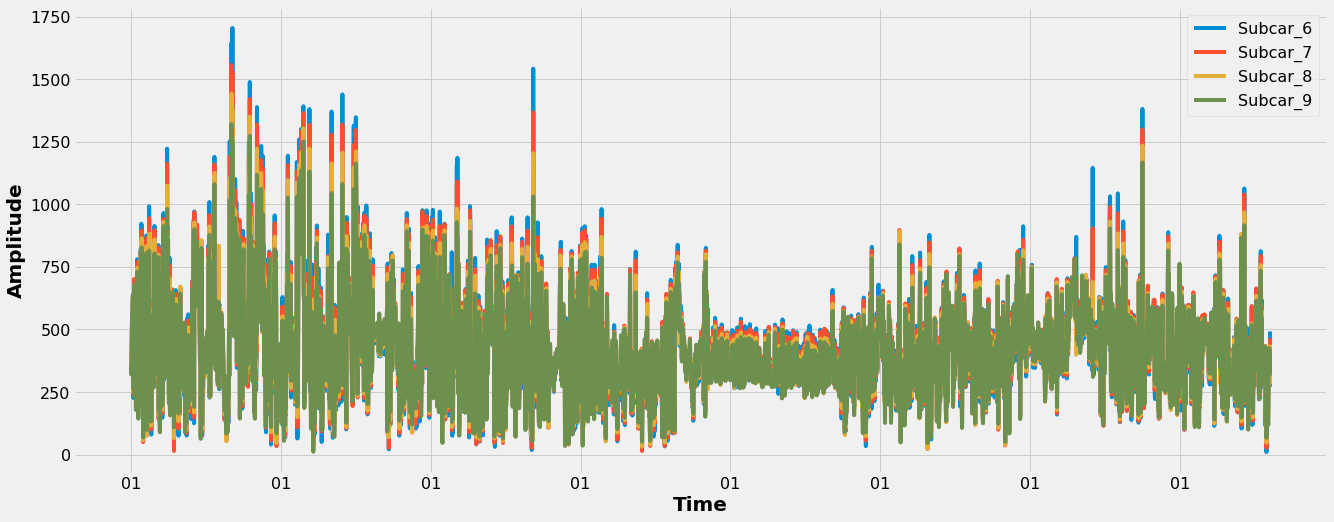

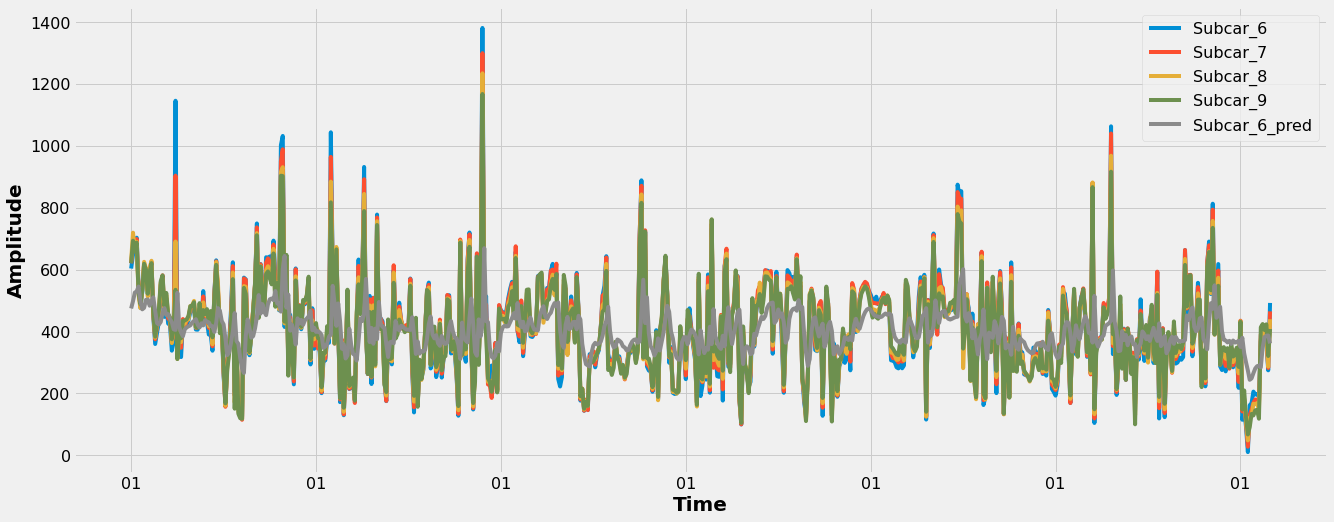

In [85]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']
plot_features = df_input[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/raw_standard.png', dpi=500)


df_final_lstm[['Subcar_6', 'Subcar_6_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/pred_standard.png', dpi=500)


In [87]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [88]:
cp3 = ModelCheckpoint('../save/gru_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [90]:
history_2 = gru_model.fit(
    train_generator, epochs=10,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/10
91/91 [==============================] - 28s 312ms/step - loss: 0.9154 - mean_absolute_error: 0.6846 - val_loss: 0.5782 - val_mean_absolute_error: 0.5637
Epoch 2/10
91/91 [==============================] - 23s 250ms/step - loss: 0.8566 - mean_absolute_error: 0.6671 - val_loss: 0.5667 - val_mean_absolute_error: 0.5544
Epoch 3/10
91/91 [==============================] - 22s 247ms/step - loss: 0.8230 - mean_absolute_error: 0.6556 - val_loss: 0.5623 - val_mean_absolute_error: 0.5508
Epoch 4/10
91/91 [==============================] - 23s 251ms/step - loss: 0.8005 - mean_absolute_error: 0.6456 - val_loss: 0.5605 - val_mean_absolute_error: 0.5492
Epoch 5/10
91/91 [==============================] - 26s 289ms/step - loss: 0.7880 - mean_absolute_error: 0.6398 - val_loss: 0.5596 - val_mean_absolute_error: 0.5493
Epoch 6/10
91/91 [==============================] - 24s 263ms/step - loss: 0.7786 - mean_absolute_error: 0.6352 - val_loss: 0.5593 - val_mean_absolute_error: 0.5500
Epoch 7/10

In [92]:
history_2.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

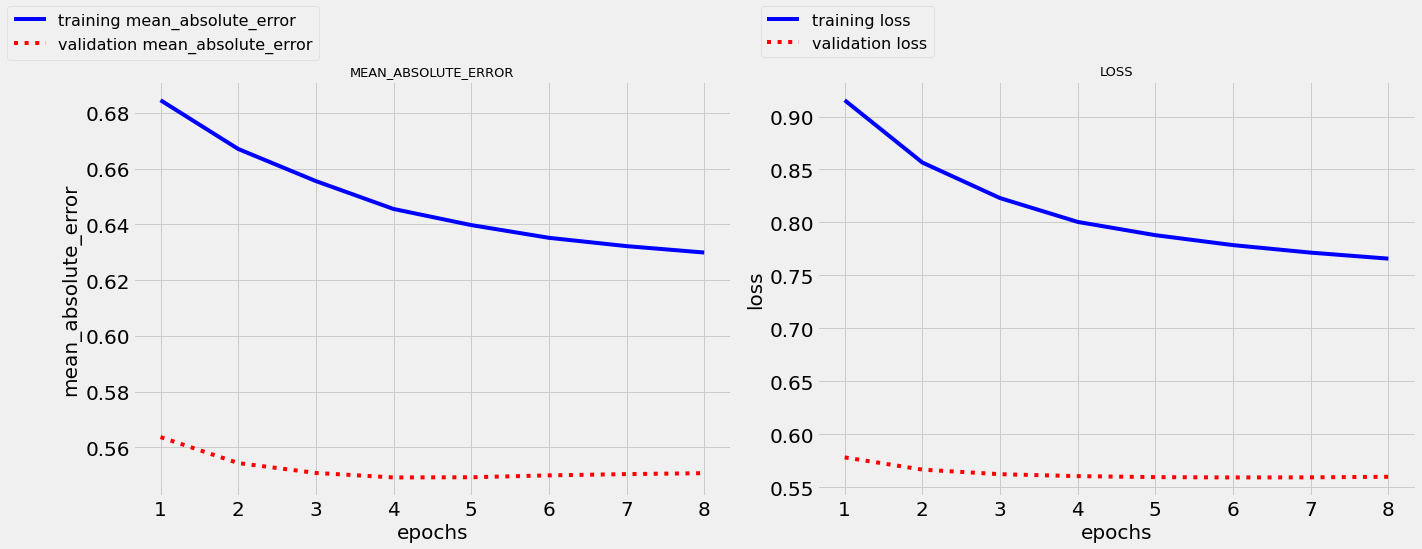

In [93]:
plot_history(history_2)

In [94]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model_standard/')

In [95]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = lstm_model.evaluate(train_generator)
performance['BiLSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 12s 128ms/step - loss: 0.7829 - mean_absolute_error: 0.6331


In [96]:
predictions_gru = gru_model.predict(test_generator)
predictions_gru

array([[ 2.51268893e-01],
       [ 3.71858805e-01],
       [ 5.40592730e-01],
       [ 6.33660495e-01],
       [ 7.35395014e-01],
       [ 6.03987753e-01],
       [ 4.36612606e-01],
       [ 3.77360761e-01],
       [ 4.45448518e-01],
       [ 4.59011823e-01],
       [ 3.73552740e-01],
       [ 4.20048207e-01],
       [ 4.76055950e-01],
       [ 2.87101209e-01],
       [ 4.52254154e-02],
       [-5.16954400e-02],
       [-5.41513152e-02],
       [ 8.63464326e-02],
       [ 2.18051568e-01],
       [ 1.64963290e-01],
       [ 1.93847686e-01],
       [ 1.23768046e-01],
       [ 6.78745732e-02],
       [-5.09703942e-02],
       [-7.54493847e-02],
       [ 3.73186916e-01],
       [ 1.40787169e-01],
       [ 5.66813610e-02],
       [-4.56879102e-02],
       [-2.64002569e-02],
       [-2.17066966e-02],
       [-1.03022233e-02],
       [ 1.44582912e-02],
       [ 6.89075589e-02],
       [ 1.19203113e-01],
       [ 1.64447695e-01],
       [ 8.55497643e-02],
       [ 2.19855271e-02],
       [ 7.0

In [97]:
predictions_gru.shape[0]


617

In [98]:
predictions_gru

array([[ 2.51268893e-01],
       [ 3.71858805e-01],
       [ 5.40592730e-01],
       [ 6.33660495e-01],
       [ 7.35395014e-01],
       [ 6.03987753e-01],
       [ 4.36612606e-01],
       [ 3.77360761e-01],
       [ 4.45448518e-01],
       [ 4.59011823e-01],
       [ 3.73552740e-01],
       [ 4.20048207e-01],
       [ 4.76055950e-01],
       [ 2.87101209e-01],
       [ 4.52254154e-02],
       [-5.16954400e-02],
       [-5.41513152e-02],
       [ 8.63464326e-02],
       [ 2.18051568e-01],
       [ 1.64963290e-01],
       [ 1.93847686e-01],
       [ 1.23768046e-01],
       [ 6.78745732e-02],
       [-5.09703942e-02],
       [-7.54493847e-02],
       [ 3.73186916e-01],
       [ 1.40787169e-01],
       [ 5.66813610e-02],
       [-4.56879102e-02],
       [-2.64002569e-02],
       [-2.17066966e-02],
       [-1.03022233e-02],
       [ 1.44582912e-02],
       [ 6.89075589e-02],
       [ 1.19203113e-01],
       [ 1.64447695e-01],
       [ 8.55497643e-02],
       [ 2.19855271e-02],
       [ 7.0

In [99]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru

,0,0,1,2
0,0.251269,1.024170,1.181653,1.223469
1,0.371859,1.299629,1.682031,1.646456
2,0.540593,1.254683,1.393705,1.441127
3,0.633660,1.428023,1.518551,1.610747
4,0.735395,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.457461,-0.139950,-0.002518,0.078249
613,-0.323620,-0.213699,-0.106270,-0.033622
614,-0.256989,-0.207201,-0.153982,0.073246
615,-0.223209,-0.725259,-0.700527,-0.522284


In [100]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[473.79550677, 620.6271022 , 628.434563  , 620.7624344 ],
       [498.20608563, 673.9332311 , 719.3364998 , 693.4118545 ],
       [532.3622825 , 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [370.91071492, 382.3349317 , 385.7939865 , 423.2079867 ],
       [377.74858915, 282.0815485 , 286.5047993 , 320.9236669 ],
       [358.36365063, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [101]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]

In [102]:
df_final_gru['Subcar_6_pred'] = rev_trans[:, 0]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_6_pred
Time,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,473.795507
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,498.206086
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,532.362283
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,551.201653
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,571.795403
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,330.329907
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,357.422833
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,370.910715


In [104]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [105]:
cp4 = ModelCheckpoint('../save/conv_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [106]:
history_3 = conv_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/15
91/91 [==============================] - 1s 11ms/step - loss: 1.1160 - mean_absolute_error: 0.7802 - val_loss: 0.6442 - val_mean_absolute_error: 0.6137
Epoch 2/15
91/91 [==============================] - 1s 10ms/step - loss: 1.1075 - mean_absolute_error: 0.7740 - val_loss: 0.6433 - val_mean_absolute_error: 0.6141
Epoch 3/15
91/91 [==============================] - 1s 11ms/step - loss: 1.1087 - mean_absolute_error: 0.7727 - val_loss: 0.6375 - val_mean_absolute_error: 0.6145
Epoch 4/15
91/91 [==============================] - 0s 5ms/step - loss: 1.0983 - mean_absolute_error: 0.7690 - val_loss: 0.6376 - val_mean_absolute_error: 0.6146
Epoch 5/15
91/91 [==============================] - 1s 10ms/step - loss: 1.0973 - mean_absolute_error: 0.7691 - val_loss: 0.6371 - val_mean_absolute_error: 0.6157
Epoch 6/15
91/91 [==============================] - 1s 10ms/step - loss: 1.0929 - mean_absolute_error: 0.7674 - val_loss: 0.6370 - val_mean_absolute_error: 0.6160
Epoch 7/15
91/91 [=====

In [107]:
history_3.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

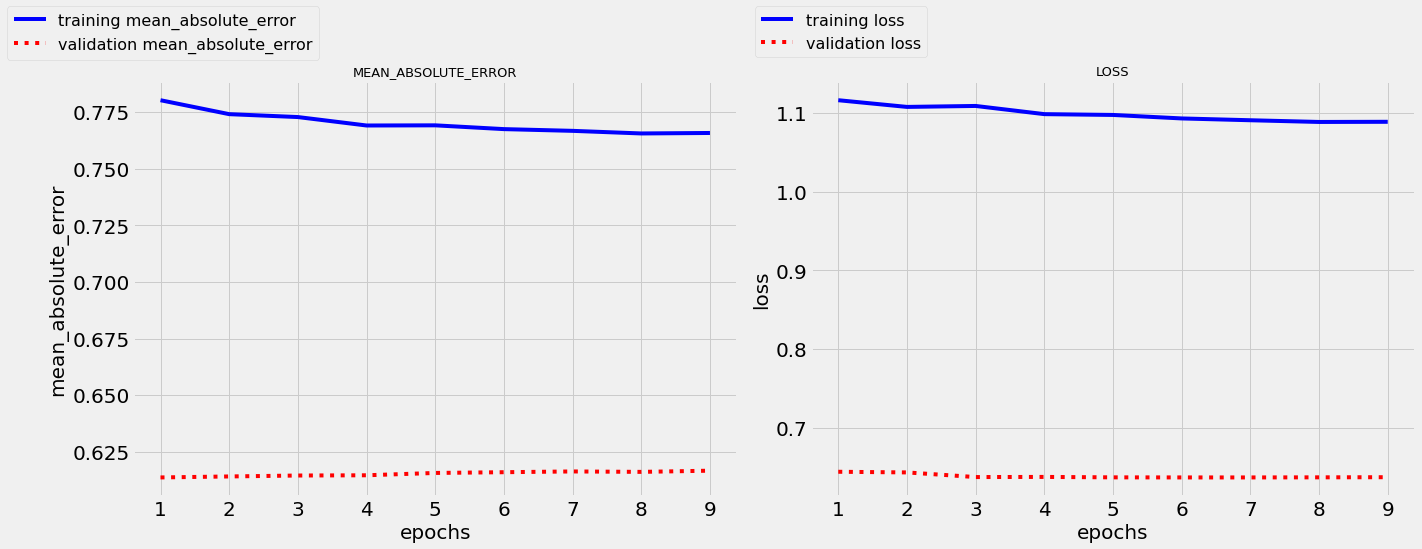

In [108]:
plot_history(history_3)

In [109]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/conv_model_standard/')


In [110]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = lstm_model.evaluate(train_generator)
performance['CONV'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 11s 124ms/step - loss: 0.7829 - mean_absolute_error: 0.6331


In [111]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv

array([[[-0.07083772],
        [-0.04151294],
        [-0.06644081],
        ...,
        [-0.04104718],
        [-0.05386741],
        [-0.0257903 ]],

       [[-0.04151294],
        [-0.06644081],
        [-0.06178157],
        ...,
        [-0.05386741],
        [-0.0257903 ],
        [-0.01811614]],

       [[-0.06644081],
        [-0.06178157],
        [-0.05884416],
        ...,
        [-0.0257903 ],
        [-0.01811614],
        [ 0.00146129]],

       ...,

       [[-0.03410685],
        [-0.14981286],
        [-0.10430519],
        ...,
        [-0.09072888],
        [-0.06312685],
        [-0.04739654]],

       [[-0.14981286],
        [-0.10430519],
        [-0.09787041],
        ...,
        [-0.06312685],
        [-0.04739654],
        [-0.06377979]],

       [[-0.10430519],
        [-0.09787041],
        [-0.07754584],
        ...,
        [-0.04739654],
        [-0.06377979],
        [-0.09483874]]], dtype=float32)

In [112]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2
0,0.251269,1.024170,1.181653,1.223469
1,0.371859,1.299629,1.682031,1.646456
2,0.540593,1.254683,1.393705,1.441127
3,0.633660,1.428023,1.518551,1.610747
4,0.735395,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.457461,-0.139950,-0.002518,0.078249
613,-0.323620,-0.213699,-0.106270,-0.033622
614,-0.256989,-0.207201,-0.153982,0.073246
615,-0.223209,-0.725259,-0.700527,-0.522284


In [113]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[473.79550677, 620.6271022 , 628.434563  , 620.7624344 ],
       [498.20608563, 673.9332311 , 719.3364998 , 693.4118545 ],
       [532.3622825 , 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [370.91071492, 382.3349317 , 385.7939865 , 423.2079867 ],
       [377.74858915, 282.0815485 , 286.5047993 , 320.9236669 ],
       [358.36365063, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [114]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]


In [115]:
df_final_conv['Subcar_6_pred'] = rev_trans_conv[:, 0]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_6_pred
Time,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,473.795507
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,498.206086
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,532.362283
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,551.201653
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,571.795403
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,330.329907
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,357.422833
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,370.910715


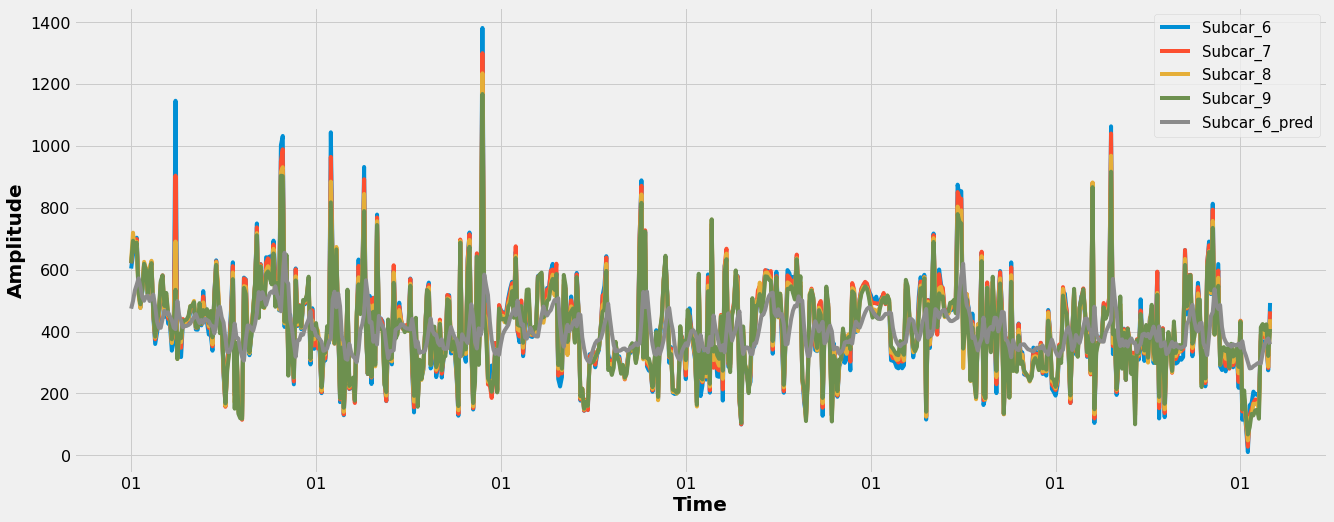

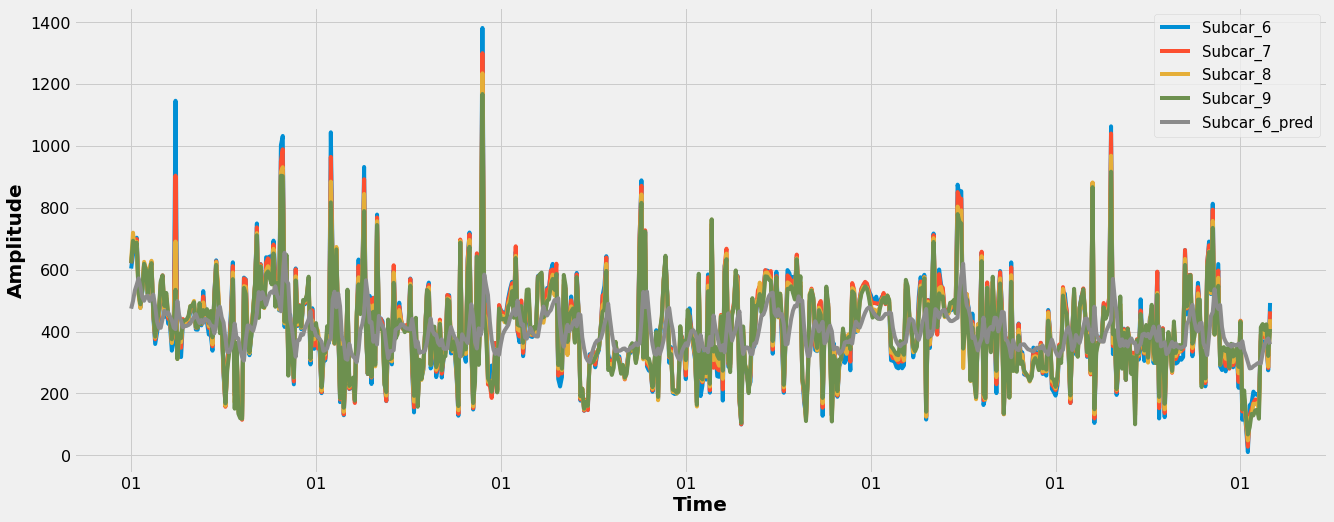

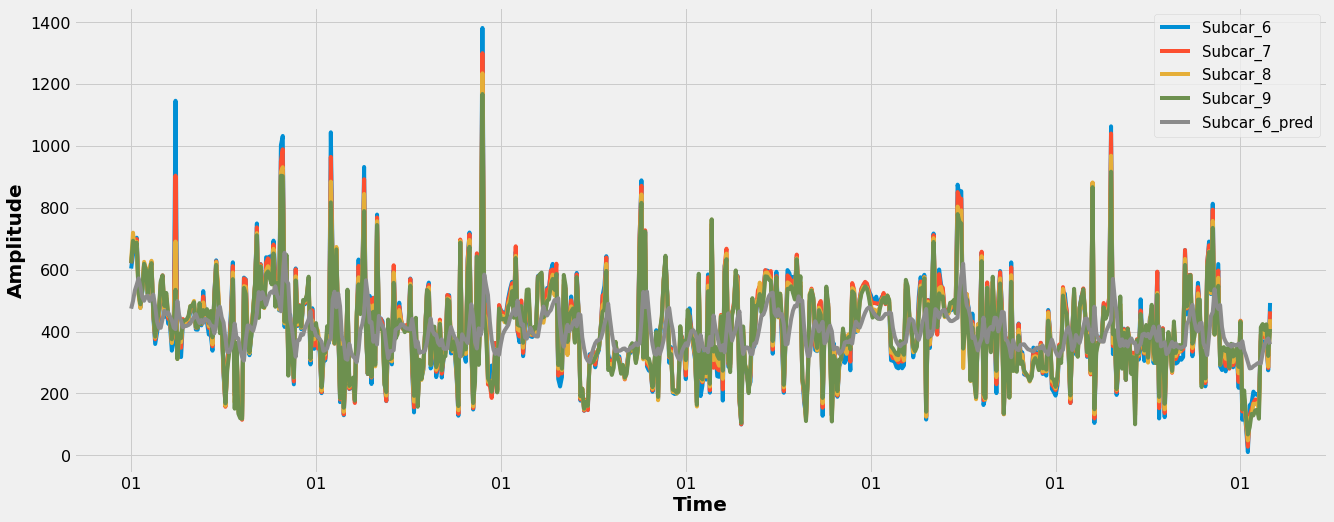

In [116]:

df_final_gru[['Subcar_6', 'Subcar_6_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
            horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve_standard.eps', dpi=300)

df_final_gru[['Subcar_6', 'Subcar_6_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve_standard.eps', dpi=300)

df_final_conv[['Subcar_6', 'Subcar_6_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve_standard.eps', dpi=300)

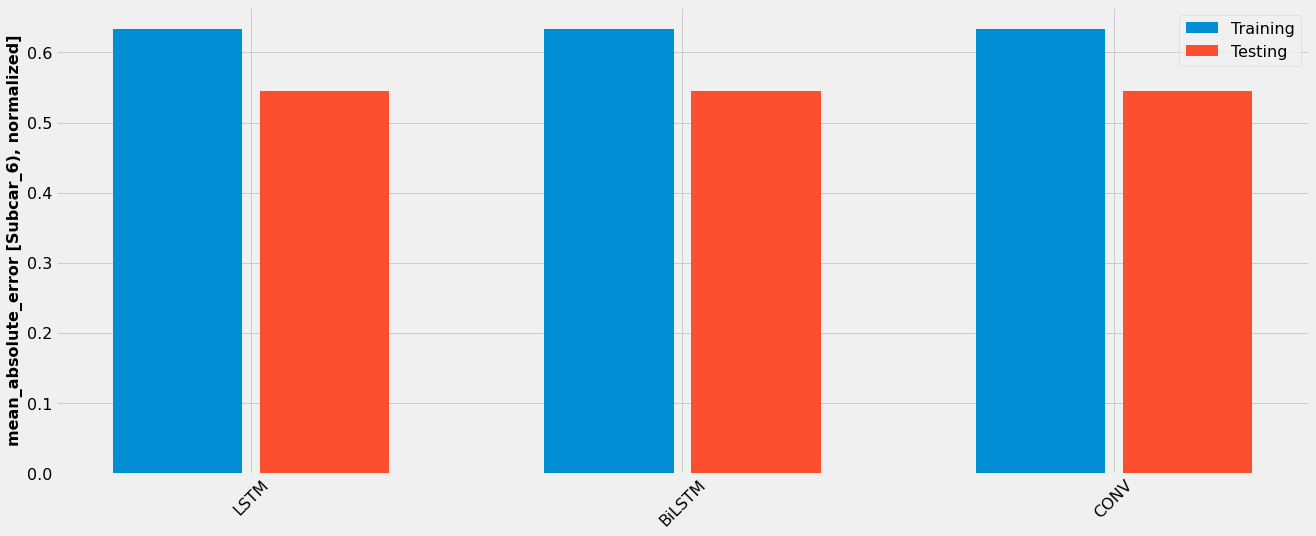

In [117]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_6), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph_standard.pdf', dpi=500)

In [118]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.5455
BiLSTM      : 0.5455
CONV        : 0.5455


In [119]:
# df_final_conv[['Subcar_7', 'Subcar_7_pred']].plot()
for name, value in val_performance.items():
      print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.6331
BiLSTM      : 0.6331
CONV        : 0.6331
